In [1]:
from __future__ import division

import os
import pandas as pd                     # library to handle data even from spreadsheets 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata  # useful for not-regular grid points
import pylab
import time
import scipy.special as bessel
import sys
import scipy.optimize as opt
from scipy.optimize import curve_fit
import matplotlib.ticker as mticker

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################


pi = math.pi                    # pi-greek
m_p = .939                      # proton mass in GeV/c^2
m_e = 0.000510998918            # electron mass in GeV/c^2
c = 2.99*pow(10,10)             # speed of light in [cm sec^(-1)]
b_0 = 1.4*pow(10,-16)           # energy loss coefficient (due to IC scattering and synchrotron) in [GeV^(-1) s^(-1)]


c2kB = 6.50966198               # divided by 10^36
pc_mt = 3.0857e+16              # parsec in meters
pc_cm = 3.0857e+18              # parsec in centimeters
m_to_pc = pow(pc_mt,-1)         # to pass from meters to parsec
cm_to_pc = 3.24 * pow(10,-19)   # to pass from centimeters to parsec
conv_factor_GeV_to_erg = 0.00160218   # the value in [GeV] has to be multipled by this factor
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56*pow(10,6)
conv_GeV_g = 1.78e-24

# <center> Plasma parameters

$$
\begin{aligned}
&x_c \equiv \left( \frac{6 \rho M_A^2 L_{\mathrm{inj}} v_A}{\eta_0} \right)^{2/3} \\
&\rho = n_{\mathrm{ISM}} \cdot m_p, \qquad \eta_0 = 6 \cdot 10^{3} \, \left( \frac{37}{\mathrm{ln} \, \Lambda} \right) \left( \frac{T_{\mathrm{ISM}}}{10^8 \, \mathrm{K}} \right)^{5/2} \frac{\mathrm{g}}{\mathrm{cm \cdot s}} \; \left( \mathrm{Spitzer} \, 1962 \right), \qquad \mathrm{ln} \, \Lambda \equiv \mathrm{ln} \, \left( \frac{b_{\mathrm{max}}}{b_{\mathrm{min}}} \right) \simeq \mathrm{ln} \, \left( \frac{\lambda_D}{b_{\mathrm{min}}} \right), \, b_{\mathrm{min}} \approx 8.63 \cdot 10^{-8} \left( \frac{10^4 \, \mathrm{K}}{T_{\mathrm{ISM}}} \right) \, \mathrm{cm} \\
& \lambda_D \approx 0.95 \cdot 10^5 \cdot \left( \frac{T}{10^6 \, \mathrm{K}} \right)^{1/2} \left( \frac{10^{-3} \, \mathrm{cm}^{-3}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm} \\
&\beta = 3.3 \cdot \left( \frac{3 \, \mu\mathrm{G}}{B_{\mathrm{Cyg}}} \right)^2 \left( \frac{n_{\mathrm{ISM}}}{1 \, \mathrm{cm^{-3}}} \right) \left( \frac{T_{\mathrm{ISM}}}{10^4 \, \mathrm{K}} \right) \\
& v_A = 6.27 \cdot 10^5 \, \left( \frac{B_{\mathrm{Cyg}}}{3 \, \mu\mathrm{G}} \right) \left( \frac{1 \, \mathrm{cm^{-3}}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm \cdot s^{-1}}
\end{aligned}
$$

In [4]:
################################
### Environmental parameters ###
################################

gamma_ratio = m_p/m_e
WIM_size = 900.               # in [pc]
Halo_size_minus_WIM = 5100.   # in [pc]


B_field = 10.         # magnetic field, in [muGauss]
n_ISM = 0.1          # density of the environment, in [cm^{-3}]
T_ISM = 5.e3         # in [K]

L_disk = 10.             # in [pc]
M_A_disk = 1.             # Alfvénic Mach Number


###
v_A = 6.27e5 * (B_field / 3.) * (1. / n_ISM)**(1/2)
rho = n_ISM * (m_p * conv_GeV_g)
Debye_length = 0.95e5 * (T_ISM / 1.e6)**(1/2) * (1.e-3 / n_ISM)**(1/2)    # in [cm]

b_min = 8.63e-8 * (1.e4 / T_ISM)                                          # in [cm]
ln_Lambda = np.log(Debye_length / b_min)
eta_0 = 6.e3 * (37 / ln_Lambda) * (T_ISM / 1.e8)**(5/2)  # in [g cm^{-1} s^{-1}]


x_c = ( (6 * rho * M_A_disk**2 * (L_disk*pc_cm) * v_A) / (eta_0) )**(2/3)
beta_disk = 3.3 * (3. / B_field)**2 * (n_ISM / 1.) * (T_ISM / 1.e4)
###


print('rho =', rho, '[g]')
print('')
print('v_A =', v_A / 1.e5, '[km s^{-1}]')
print('')
print('ln_Lambda =', ln_Lambda)
print('')
print('x_c =', x_c)
print('')
print('plasma beta =', beta_disk)

rho = 1.67142e-25 [g]

v_A = 66.09160309751913 [km s^{-1}]

ln_Lambda = 22.0821774526117

x_c = 1098163.8954614

plasma beta = 0.01485


# <center>Truncation Scale
    
### Collisionless damping

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}\\[10pt]
&\beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous)

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L_{\mathrm{inj}}}{\eta_0 \, v_A} \right)^{2/3} = \left( \frac{6 \, \rho \, M_A^2 \, L_{\mathrm{inj}} \, v_A}{\eta_0} \right)^{2/3}
\end{align}$$

In [5]:
path_updated_plots = '/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots_GSSI/'

In [6]:
p_CR = np.logspace(-1, 5, num=60)

p_CR_chosen = [1.e2, 1.e4]  # in [GeV]
indx_p_CR = [np.argmin( abs(p_CR - p_CR_chosen[i]) ) for i in range(len(p_CR_chosen))]


def Larmor_radius(p_, B_ISM_):
    # result in [cm] and [pc]
    return 3.31e+12 * (p_ / 1.) * (1. / B_ISM_), 3.31e+12 * (p_ / 1.) * (1. / B_ISM_) * cm_to_pc


ell_inverse = np.logspace(start=1., stop=10., num=700)

kL_list = [L_disk / ell_inverse[ik] for ik in range(len(ell_inverse))]

indx_result_100GeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[0]], B_field)[1] - kL_list) )
indx_result_10TeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[1]], B_field)[1] - kL_list) )

print(indx_result_100GeV, indx_result_10TeV)
print(ell_inverse[indx_result_100GeV])

390 232
1050652.8126116833


/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:21: RuntimeWarning: overflow encountered in exp
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2

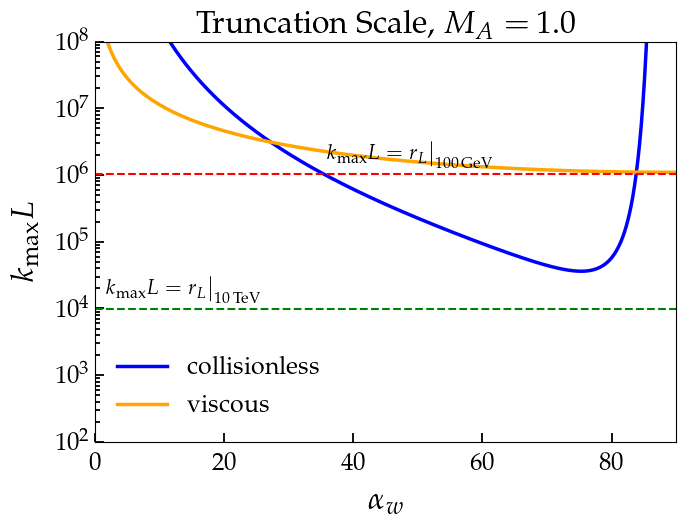

In [7]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

plt.figure(figsize=(7.5,5.2))

ax = plt.gca()
ax.tick_params(direction='in', axis='both', which='major', length=6.5, width=1.3, labelsize=18)
ax.tick_params(direction='in', axis='both', which='minor', length=3.5, width=1.3, labelsize=18)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 10


theta = np.linspace(0., 90., num=700)    # wave pitch-angle in degrees

# collisionless
def kmax_L_func_coll(theta_arr):
    kmax_L_arr_collisionless = np.zeros(len(theta_arr))
    for i in range(len(theta_arr)):
        kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
    return kmax_L_arr_collisionless

# collisional (viscous)
def kmax_L_func_visc(theta_arr):
    kmax_L_arr_viscous = np.zeros(len(theta_arr))
    for i in range(len(theta_arr)):
        kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2/3)
    return kmax_L_arr_viscous
 


kmax_L_H, = plt.plot(theta, kmax_L_func_coll(theta), lw=2.5, color='blue', label='collisionless')
kmax_L_d, = plt.plot(theta, kmax_L_func_visc(theta), lw=2.5, color='orange', label='viscous')

plt.axhline(y=ell_inverse[indx_result_100GeV], ls='--', lw=1.5, color='red')
plt.axhline(y=ell_inverse[indx_result_10TeV], ls='--', lw=1.5, color='green')

plt.text(0.4, 0.703, '$k_{\mathrm{max}}L = r_L \\big|_{100 \, \mathrm{GeV}}$', fontsize=15, transform = ax.transAxes)
plt.text(0.02, 0.366, '$k_{\mathrm{max}}L = r_L \\big|_{10 \, \mathrm{TeV}}$', fontsize=15, transform = ax.transAxes)


plt.title('Truncation Scale, $M_A = \,$' + str(M_A_disk), fontsize=23, loc='center', pad=None)
plt.axis([0.,90., 1.e2,1.e8])
plt.xlabel('$\\alpha_w$',fontsize=23)
plt.ylabel('$k_\mathrm{max}L$',fontsize=23)
plt.yscale('log')
plt.legend(fontsize=18, frameon=False, loc='best')

plt.savefig(path_updated_plots + 'Truncation_scales.pdf',format='pdf',bbox_inches='tight', dpi=200)

/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:21: RuntimeWarning: overflow encountered in exp
  kmax_L_arr_collisionless[i] = ( 4 * pow(M_A_disk,4) * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) / ( pi * beta_disk * ( pow(np.sin(np.radians(theta[i])),4) ) ) * np.exp(2 / ( beta_disk * gamma_ratio * pow(np.cos(np.radians(theta[i])),2) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/1339615821.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  kmax_L_arr_viscous[i] = x_c * pow( 1 - pow(np.cos(np.radians(theta[i])),2) , -2

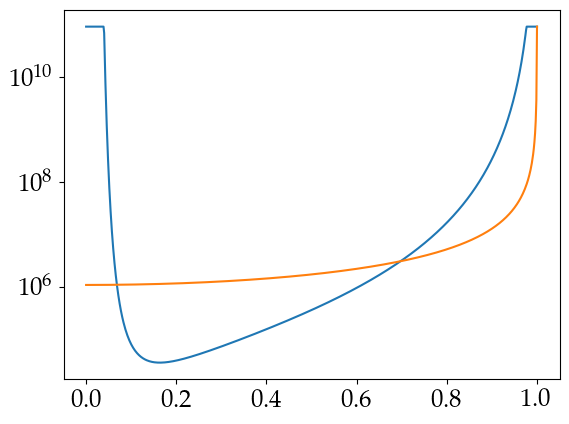

In [8]:
# dissipation-scale of the turbulence
r_L_minE = 3.31 * pow(10,10)  # in [cm], for 10^{-2} GeV particles
r_L_inverse_minE_2ordersMore = ( 1 / (r_L_minE) ) * pow(10,2)  # max k

kmax_L_coll_array = np.zeros( len(theta)  )
kmax_L_coll_minscale = np.zeros( len(theta)  )
kmax_L_visc_array = np.zeros( len(theta)  )
kmax_L_visc_minscale = np.zeros( len(theta)  )

kmax_L_reversed_coll = np.zeros( len(theta)  )
kmax_L_reversed_visc = np.zeros( len(theta)  )


kmax_L_coll_array = kmax_L_func_coll(theta)
for j in range(len(theta)):
    kmax_L_coll_minscale[j] = min(kmax_L_coll_array[j], r_L_inverse_minE_2ordersMore * (L_disk*pc_cm))
kmax_L_reversed_coll = kmax_L_coll_minscale[::-1]

kmax_L_visc_array = kmax_L_func_visc(theta)
for i in range(len(theta)):
    kmax_L_visc_minscale[i] = min(kmax_L_visc_array[i], r_L_inverse_minE_2ordersMore * (L_disk*pc_cm))

kmax_L_reversed_visc = kmax_L_visc_minscale[::-1]

csi = np.linspace(0., 1., num=len(theta))

plt.plot(csi, kmax_L_reversed_coll)   # just to check it's correct
plt.plot(csi, kmax_L_reversed_visc)
#plt.axis([0.,1., 1.e2,1.e15],interpolation='none')
plt.yscale('log')

# <center>Diffusion Coefficient

### $D_{\mu \mu}$ for fast-modes TTD

$$\begin{align}
&D^{T}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \\[10pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2} \\[10pt]
&R = \frac{r_L}{L}
\end{align}$$

### $D_{\mu \mu}$ for fast-modes Gyroresonance

$$D^{G}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \sum^{+\infty}_{n=-\infty} J_n^{'2}(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} }$$

$$(D^{G, n=+1}_{\mu \mu} + D^{G, n=-1}_{\mu \mu}) \cdot \frac{L}{v} = \frac{M_A^{3/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, x^{-5/2} \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \right) $$

### $D_{\mu \mu}$ for Alfvén modes
### $(M_A \leq 1)$

$$ D^A_{\mu \mu} = \frac{2 v M^{4/3}_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)}$$

$$\begin{align}
&\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{5/6} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)  \\[10pt]
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{-2}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} = 1, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$

### $(M_A > 1)$

$$
D^A_{\mu \mu} = \frac{2 v M_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)} $$

$$\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{1/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)$$

$$\begin{align}
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{3}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} \approx M_A^{3}, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$


### <center>Condition on each $\mu$ for diffusive regime
    
$$\left( \frac{2  D_{\mu \mu}}{1 - \mu^2} \right)^{-1} \cdot c \equiv \Delta x < \frac{L_{\mathrm{H,D}}}{5}$$


### <center>Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{\mu^*} d\mu \, \frac{v^2 \, (1 - \mu^2)^2}{D^{f,T}_{\mu \mu}  + D^{f,G}_{\mu \mu} + D^{A,G}_{\mu \mu}}$$

In [9]:
########################################
### Calculate the D(R) in the Disk #####
########################################

### Calculate the D_mumu in the Disk ###

# Define the integration variables #
length_energy_array = 60
length_mu_array = 30
length_x_perp_alf_disk_array = 100       # 800/1000
length_x_parallel_alf_disk_array = 100   # 800/1000
length_x_array = 100


p_CR = np.logspace(-1, 5, num=length_energy_array)
r_L = np.zeros(len(p_CR))
R_disk = np.zeros(len(p_CR))

r_L = [3.31 * pow(10,12) / B_field * p_CR[i] for i in range(len(p_CR))]   # (p/1GeV)*(1/Z)*(10^{-6}G/B), in [cm] and c=1
R_disk = [r_L[i] / (L_disk*pc_cm) for i in range(len(p_CR))]


mu = np.linspace(0., 0.999, num=length_mu_array)          # problems with 0° pitch-angle scattering


x_perp_max_disk = r_L_inverse_minE_2ordersMore * (L_disk*pc_cm)
x_parallel_max_disk = pow(x_perp_max_disk, 2/3)


if (M_A_disk <= 1):
    x_perp_min_disk = pow(M_A_disk, -2)
    x_parallel_min_disk = 1
    
elif (M_A_disk > 1):
    x_perp_min_disk = pow(M_A_disk, 3)
    x_parallel_min_disk = pow(M_A_disk, 3)
    
        

# Fast Modes
bessel_arg_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
# TTD
bessel_func_square_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_TTD = np.zeros( (len(mu),len(csi)) )
integrand_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integral_over_x_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_TTD_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TTD_over_v_disk = np.zeros( (len(R_disk),len(mu)) )

# Gyroresonance
bessel_func_square_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_Gyro_disk_2 = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integrand_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integral_over_x_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_Gyro_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Gyro_over_v_disk = np.zeros( (len(R_disk),len(mu)) )


# Alfvén modes
x_perp_alf_disk = np.logspace(np.log10(x_perp_min_disk), np.log10(x_perp_max_disk), length_x_perp_alf_disk_array) 
x_parallel_alf_disk = np.logspace(np.log10(x_parallel_min_disk), np.log10(x_parallel_max_disk), length_x_parallel_alf_disk_array) 

bessel_arg_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )
bessel_func_square_alf_disk_ratio = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )
power_alf_disk = np.zeros( (len(x_parallel_alf_disk), len(x_perp_alf_disk)) )
exponential_arg_alf_disk_first = np.zeros( (len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
exponential_arg_alf_disk_second = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_arg_alf_disk_second_2 = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
integrand_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
integral_over_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
integral_over_xparallel_alf_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Alfven_over_v_disk = np.zeros( (len(R_disk),len(mu)) )

# Total
integrand_mu_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TOT_disk = np.zeros( (len(R_disk),len(mu)) )
scattering_frequency_disk = np.zeros( (len(R_disk),len(mu)) )
integral_over_mu_disk = np.zeros( len(R_disk) )  
        
        
        
        



print ("Length of R array:", len(R_disk), "in the range:", min(R_disk),max(R_disk))
print ("Length of mu array:", len(mu), "in the range:", min(mu),max(mu))
print ("Length of theta array:", len(theta), "in the range:", min(theta),max(theta))
print ("Length of csi array (must be the same as theta):", len(csi), "in the range:", min(csi),max(csi))
print ("Length of kmax_L_viscous array (must be the same as theta):", len(kmax_L_reversed_visc), "in the range:", min(kmax_L_reversed_visc),max(kmax_L_reversed_visc))
print ("Length of kmax_L_collisionless array (must be the same as theta):", len(kmax_L_reversed_coll), "in the range:", min(kmax_L_reversed_coll),max(kmax_L_reversed_coll))
print('')



start_time = time.process_time()

start_advancing = time.process_time()
for r in range(len(R_disk)):
    
    print('Index:', r, '/ ' + str(length_energy_array-1) + ', R:', R_disk[r])
    
    for m in range(len(mu)):
        
        # Fast modes
        for i in range(len(csi)):

            # building the array for the integration variable x #
            x_array_disk = np.logspace(0, np.log10( min( kmax_L_reversed_visc[i],kmax_L_reversed_coll[i] ) ), num=length_x_array)
            
            power_disk = np.zeros(len(x_array_disk))

            exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_disk) ) )
            
            for j in range(len(x_array_disk)):

                bessel_arg_disk[r][m][i][j] = R_disk[r] * x_array_disk[j] * pow( (1 - pow(csi[i],2)),1/2 ) * pow( (1 - pow(mu[m],2)),1/2 )
                power_disk[j] = pow(x_array_disk[j], -5/2)

                bessel_func_square_TTD_disk[r][m][i][j] = pow(bessel.jv(1,bessel_arg_disk[r][m][i][j]),2)
                integrand_TTD_disk[r][m][i][j] = csi[i] * bessel_func_square_TTD_disk[r][m][i][j] * power_disk[j] * exponential_TTD[m][i]

                bessel_func_square_Gyro_disk[r][m][i][j] = pow( ( bessel.jv(0,bessel_arg_disk[r][m][i][j]) - bessel.jv(2,bessel_arg_disk[r][m][i][j]) )/2,2 )
                exponential_Gyro_disk[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                exponential_Gyro_disk_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                integrand_Gyro_disk[r][m][i][j] = csi[i] * bessel_func_square_Gyro_disk[r][m][i][j] * power_disk[j] * (exponential_Gyro_disk[r][m][i][j] + exponential_Gyro_disk_2[r][m][i][j])

            integral_over_x_TTD_disk[r][m][i] = integrate.trapz(integrand_TTD_disk[r][m][i], x_array_disk)
            integral_over_x_Gyro_disk[r][m][i] = integrate.trapz(integrand_Gyro_disk[r][m][i], x_array_disk)

        integral_over_csi_TTD_disk[r][m] = integrate.trapz(integral_over_x_TTD_disk[r][m], csi)
        integral_over_csi_Gyro_disk[r][m] = integrate.trapz(integral_over_x_Gyro_disk[r][m], csi)
        # End of the fast modes
        
        if (M_A_disk <= 1.):
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( pow(M_A_disk,4/3) * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,5/6) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]
            
        else:
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( M_A_disk * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,1/2) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]


        D_mumu_TTD_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_TTD_disk[r][m]
        D_mumu_Gyro_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_Gyro_disk[r][m]
        
        D_mumu_TOT_disk[r][m] = (D_mumu_Alfven_over_v_disk[r][m] + D_mumu_TTD_over_v_disk[r][m] + D_mumu_Gyro_over_v_disk[r][m])*c/(L_disk*pc_cm)
        scattering_frequency_disk[r][m] = (2 * D_mumu_TOT_disk[r][m]) / (1 - mu[m]**2)
        
        if ( c/scattering_frequency_disk[r][m] <= (WIM_size*pc_cm)):
            integrand_mu_disk[r][m] = 1/8 * ( c**2 / D_mumu_TOT_disk[r][m] ) * pow( 1 - mu[m]**2 , 2 )
        else:
            # I am not filling the array "integrand_mu_disk", because it's already filled with zeros,
            # so the integral will sum only zeros
            print ("For R =", R_disk[r], ", mu =", mu[m], "generates ballistic motion")
        
    print('Advancing time:', time.process_time() - start_advancing, "seconds")
    print('')
        

print ("Length of x array:", len(x_array_disk), "in the range:", min(x_array_disk),max(x_array_disk))

print("End of the calculation of the D_mumu. It took:", time.process_time() - start_time, "seconds")

/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/554241025.py:115: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_disk) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/554241025.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_Gyro_disk[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )
/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/554241025.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  exponential_Gyro_disk_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )


Length of R array: 60 in the range: 1.0726901513432933e-09 0.0010726901513432932
Length of mu array: 30 in the range: 0.0 0.999
Length of theta array: 700 in the range: 0.0 90.0
Length of csi array (must be the same as theta): 700 in the range: 0.0 1.0
Length of kmax_L_viscous array (must be the same as theta): 700 in the range: 1098163.8954614 93223564954.68277
Length of kmax_L_collisionless array (must be the same as theta): 700 in the range: 36174.192427370996 93223564954.68277

Index: 0 / 59, R: 1.0726901513432933e-09
Advancing time: 22.934681 seconds

Index: 1 / 59, R: 1.3557175200805412e-09
Advancing time: 45.413970000000006 seconds

Index: 2 / 59, R: 1.7134211514403349e-09
Advancing time: 68.01166500000001 seconds

Index: 3 / 59, R: 2.1655042431174836e-09
Advancing time: 90.595481 seconds

Index: 4 / 59, R: 2.736868646110628e-09
Advancing time: 113.81872700000001 seconds

Index: 5 / 59, R: 3.4589865200541424e-09
Advancing time: 136.989541 seconds

Index: 6 / 59, R: 4.37163389734

In [10]:
### Integrate to obtain D(R) ###

for i in range(len(R_disk)):
    integral_over_mu_disk[i] = integrate.trapz(integrand_mu_disk[i], mu)
    
print (integral_over_mu_disk)

[7.06025156e+26 6.91253167e+26 6.76671350e+26 6.62283926e+26
 6.48135706e+26 6.34205738e+26 6.20532333e+26 6.07219751e+26
 5.94238021e+26 5.81659368e+26 5.69563689e+26 5.58026684e+26
 5.47136949e+26 5.36993654e+26 5.27699863e+26 5.19404202e+26
 5.12268709e+26 5.06489231e+26 5.02288774e+26 4.99934725e+26
 4.99743843e+26 5.02101281e+26 5.07473036e+26 5.16508567e+26
 5.30263830e+26 5.50210711e+26 5.77555300e+26 6.12583658e+26
 6.54890839e+26 7.04068962e+26 7.60117561e+26 8.23531053e+26
 8.95105207e+26 9.75604426e+26 1.06583859e+27 1.16694412e+27
 1.28025037e+27 1.40736477e+27 1.55017742e+27 1.71085827e+27
 1.89191135e+27 2.09623612e+27 2.32718861e+27 2.58866772e+27
 2.88520644e+27 3.22203895e+27 3.60509765e+27 4.04085217e+27
 4.53581601e+27 5.09609536e+27 5.72798197e+27 6.43954911e+27
 7.24094813e+27 8.14317034e+27 9.15817330e+27 1.02997636e+28
 1.15828717e+28 1.30240838e+28 1.46421332e+28 1.64562476e+28]


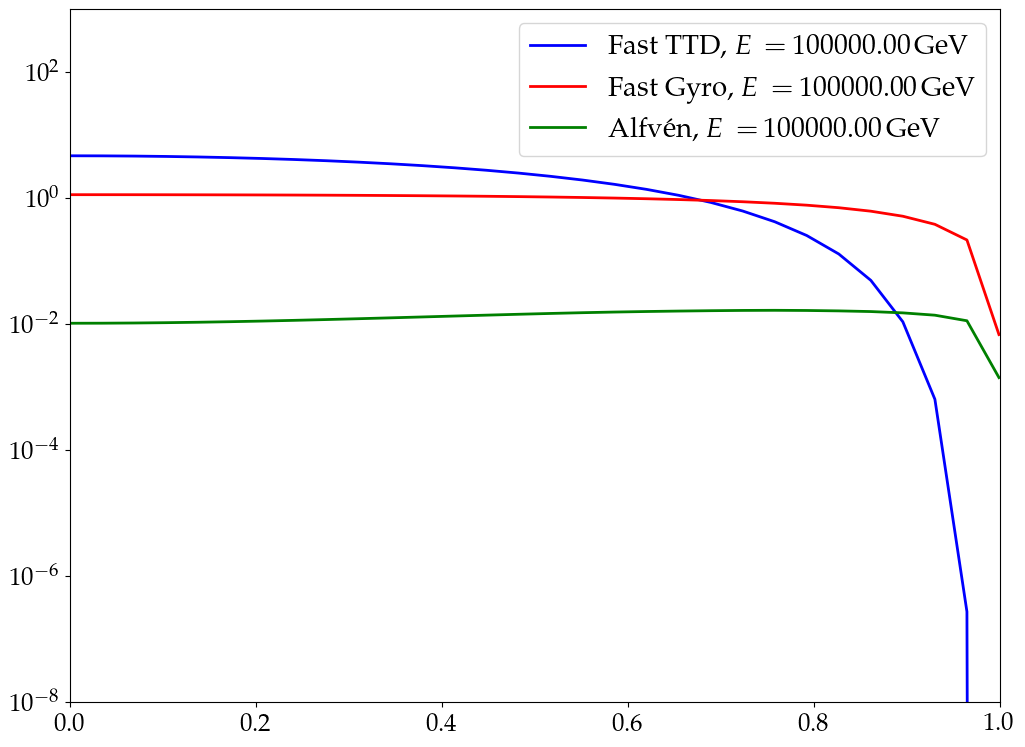

In [11]:
# This block shows the relative contributions of the three modes #

plt.figure(figsize=(12,9))

index_energy = 59   # 5, 30, 59 

plt.plot(mu, D_mumu_TTD_over_v_disk[index_energy], lw=2, color='blue', label='Fast TTD, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Gyro_over_v_disk[index_energy], lw=2, color='red', label='Fast Gyro, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Alfven_over_v_disk[index_energy], lw=2, color='green', label='Alfvén, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')

plt.xlim(0., 1.)
plt.ylim(1.e-8, 1.e+3)
plt.yscale('log')

plt.legend(fontsize=20)

name_saved_pdf_D_mumu = 'D_mumu_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'_E'+str( "{:.2f}".format(p_CR[index_energy]) )+'.pdf'
plt.savefig('/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots/Parametric_study_100TeV/Scattering_efficiency_plots_100TeV/'+str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200)
#plt.savefig('/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots/Parametric_study_correct/Scattering_efficiency_plots_correct/'+str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200)


I am fitting the curve between 9.541723680522495e-07 and 9.92146919259467e-06
29 39
Fit results: [14.65368863  0.38713988  1.        ]


/var/folders/7v/3qsg7nrd5fx6_1r1kwx67hlm0000gn/T/ipykernel_42701/2755852486.py:37: RuntimeWarning: overflow encountered in power
  return pow(10,28) * a * pow(x, b) + c
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


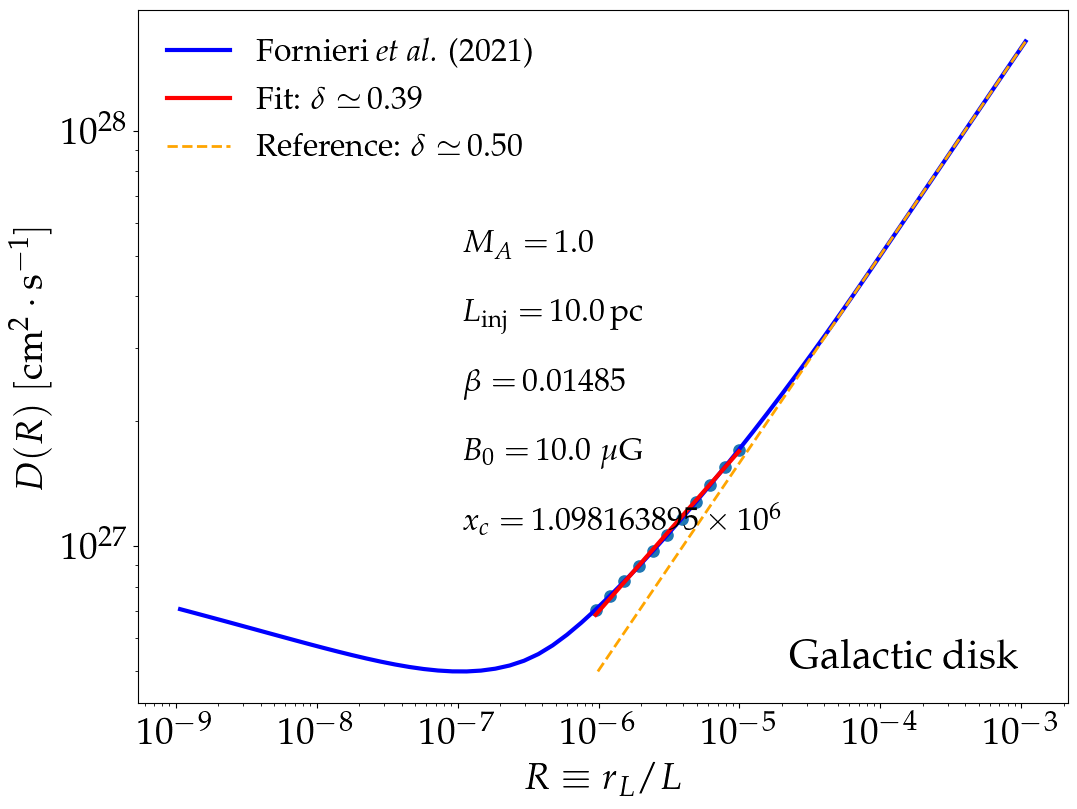

In [12]:
### Plotting block, to study ###


plt.figure(figsize=(12,9))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


YL08_disk, = plt.plot(R_disk, integral_over_mu_disk, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')


## Fitting my curve in the requested range ##
R_disk_np = np.asarray(R_disk)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", R_disk[index_requested_energy_low], "and", R_disk[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up+1)
fitting_points = integral_over_mu_disk[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, R_disk_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

my_curve_disk, = plt.plot(R_disk_np[fitting_index_range], fit_func(R_disk_np[fitting_index_range], *popt),  color='red', lw=3, ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
plt.scatter(R_disk_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################


## Draw the asymptote ##
slope_as = 0.5

x_max = max(R_disk)
y_max = max(integral_over_mu_disk)
y_min = min(integral_over_mu_disk)

x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(R_disk), num=100)

plt.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


plt.xlabel('$R \\equiv r_L/L$',fontsize=27)
plt.ylabel('$D(R) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')


plt.legend(loc='best', frameon=False, fontsize=23)


plt.text(0.35, 0.65, r'$M_{A} = \,$'+str(M_A_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.55, r'$L_{\mathrm{inj}} = \,$'+str(L_disk)+'$\, \mathrm{pc}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.45, r'$\beta = \,$'+str(beta_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.35, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.25, r'$x_c = \,$'+str("${}$".format(f.format_data(x_c))),fontsize=23, transform = ax.transAxes)
plt.text(0.7, 0.05, 'Galactic disk', fontsize=29, transform = ax.transAxes)


name_saved_pdf = 'D_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.pdf'
plt.savefig(path_updated_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)


I am fitting the curve between 88.95134973108236 and 924.9147277217335
29 39
Fit results: [0.0124345  0.38124775 1.        ]


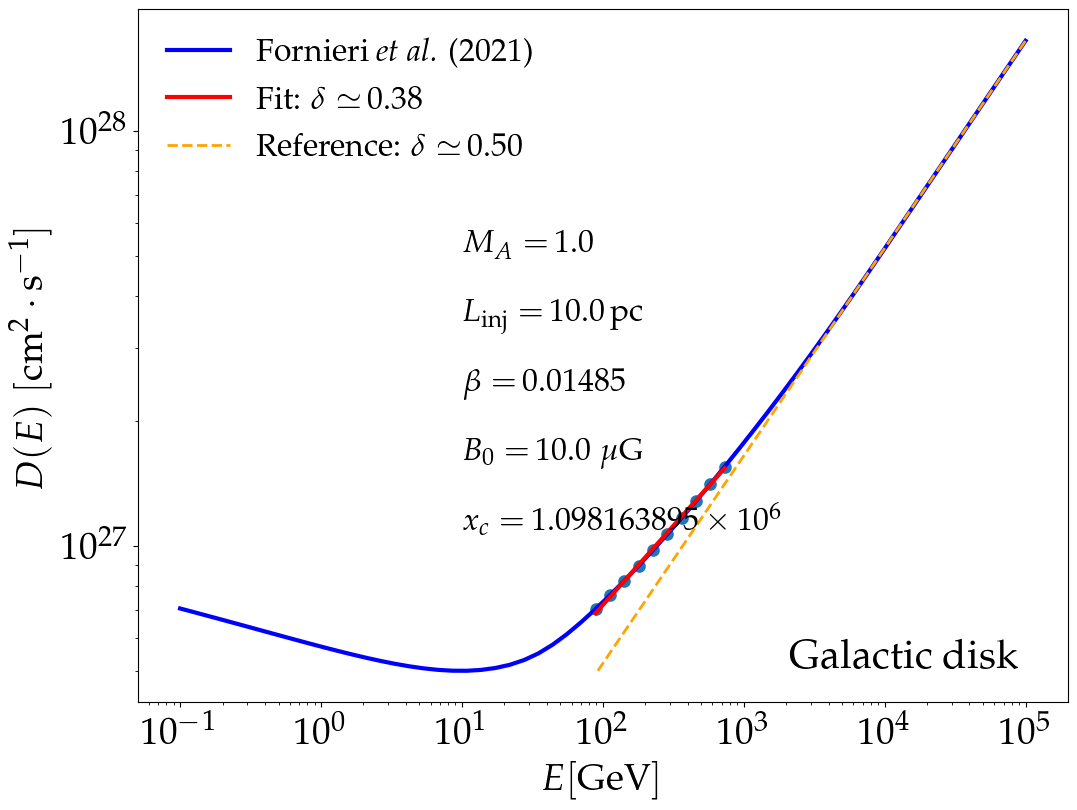

In [13]:
### Plotting block as a function of energy, to study ###


plt.figure(figsize=(12,9))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


plt.plot(p_CR, integral_over_mu_disk, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')


## Fitting my curve in the requested range ##
p_CR_np = np.asarray(p_CR)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", p_CR[index_requested_energy_low], "and", p_CR[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up)
fitting_points = integral_over_mu_disk[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, p_CR_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

plt.plot(p_CR_np[fitting_index_range], fit_func(p_CR_np[fitting_index_range], *popt),  color='red', lw=3, ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
plt.scatter(p_CR_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################


## Draw the asymptote ##
slope_as = 0.5

x_max = max(p_CR)
y_max = max(integral_over_mu_disk)
y_min = min(integral_over_mu_disk)

x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(p_CR), num=100)

plt.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


plt.xlabel('$E [\mathrm{GeV}]$',fontsize=27)
plt.ylabel('$D(E) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')


plt.legend(loc='best', frameon=False, fontsize=23)


plt.text(0.35, 0.65, r'$M_{A} = \,$'+str(M_A_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.55, r'$L_{\mathrm{inj}} = \,$'+str(L_disk)+'$\, \mathrm{pc}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.45, r'$\beta = \,$'+str(beta_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.35, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.25, r'$x_c = \,$'+str("${}$".format(f.format_data(x_c))),fontsize=23, transform = ax.transAxes)
plt.text(0.7, 0.05, 'Galactic disk', fontsize=29, transform = ax.transAxes)


name_saved_pdf = 'D_E_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.pdf'
plt.savefig(path_updated_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)


In [14]:
### Block to store the output D(R) in a text file ###

print (len(p_CR), len(R_disk_np), len(integral_over_mu_disk))

data_for_text_file = np.zeros( (len(p_CR), 3) )

data_for_text_file[:,0] = p_CR
data_for_text_file[:,1] = R_disk_np
data_for_text_file[:,2] = integral_over_mu_disk

print (data_for_text_file)

txt_file_name = 'D_disk_Ldisk' + str(L_disk) + '_MA' + str(M_A_disk) + '_xc' + str(x_c) + '_Bfield' + str(B_field) + '.txt'
np.savetxt(path_updated_plots + 'Text_files_coefficients_VarB/' + txt_file_name, data_for_text_file)

60 60 60
[[1.00000000e-01 1.07269015e-09 7.06025156e+26]
 [1.26384820e-01 1.35571752e-09 6.91253167e+26]
 [1.59731228e-01 1.71342115e-09 6.76671350e+26]
 [2.01876025e-01 2.16550424e-09 6.62283926e+26]
 [2.55140652e-01 2.73686865e-09 6.48135706e+26]
 [3.22459055e-01 3.45898652e-09 6.34205738e+26]
 [4.07539297e-01 4.37163390e-09 6.20532333e+26]
 [5.15067808e-01 5.52508165e-09 6.07219751e+26]
 [6.50967523e-01 6.98286451e-09 5.94238021e+26]
 [8.22724134e-01 8.82528076e-09 5.81659368e+26]
 [1.03979842e+00 1.11538152e-08 5.69563689e+26]
 [1.31414736e+00 1.40967293e-08 5.58026684e+26]
 [1.66088278e+00 1.78161260e-08 5.47136949e+26]
 [2.09910372e+00 2.25168789e-08 5.36993654e+26]
 [2.65294846e+00 2.84579169e-08 5.27699863e+26]
 [3.35292415e+00 3.59664871e-08 5.19404202e+26]
 [4.23758716e+00 4.54561801e-08 5.12268709e+26]
 [5.35566692e+00 5.74497116e-08 5.06489231e+26]
 [6.76875001e+00 7.26077147e-08 5.02288774e+26]
 [8.55467254e+00 9.17651298e-08 4.99934725e+26]
 [1.08118075e+01 1.15977194e-07